In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['4']:
            TSS_HK.append(TSS(ll[0], int(ll[1])+int(1000)))
        


TSS_NonGene = []
with open(dic['non_gene_4'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))

bamfile = ps.AlignmentFile(dic['bam4'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
# data_x = TSSes_x[perm[:len(perm)]]
# data_y = TSSes_y[perm[:len(perm)]]
data_x = TSSes_x
data_y = TSSes_y
up = 1000
down = 1000

In [2]:
'''lstm_input'''

feature_matrix = []
for j, tss in enumerate(data_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            # ss = max(0, r.reference_start - start)
            # ee = min(r.reference_start - start + abs(r.isize), end - start)
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        wps = 0
        for r in bamfile.fetch(chrom[-1], ss+start, ee+start):
            if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
                wps += 1
            elif ee + start > r.reference_start > ss + start:
                wps -= 1
            elif ss+start < r.reference_start + abs(r.isize) < ee + start:
                wps -= 1
        ff.append(int(wps))
        feature_win[k] = np.array(ff)
        k =  k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [3]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(data_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)

cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)

In [21]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout
from keras.models import Model
from tensorflow import keras
def OCR_model():
    cnn_input = Input(shape=(cnn_x.shape[1],cnn_x.shape[2]), name='cnn_input')
    conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_input)
    cnn_output = MaxPooling1D(pool_size=2, strides=2)(conv1)
    # conv2 = Convolution1D(filters=128, kernel_size=2, strides=2, activation='relu', padding='same')(pooling1)
    # cnn_output = MaxPooling1D(pool_size=2, strides=2)(conv2)
    flatten = Flatten()(cnn_output)
    aux_output = Dense(2, activation='sigmoid', name='aux_output')(flatten)

    aux_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='aux_input')
    x = concatenate([cnn_output, aux_input])

    lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(x)
    conv = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(lstm_out)
    pool = MaxPooling1D(pool_size=2, strides=2,name='2')(conv)
    drop = Dropout(0.2)(pool)
    flatten = Flatten()(drop)
    dense = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
    drop = Dropout(0.2)(dense)
    main_output = Dense(2, activation='softmax', kernel_regularizer=None, bias_regularizer=None,name='6')(drop)

    model = Model(inputs=[cnn_input, aux_input], outputs=[main_output, aux_output])
    return model

In [29]:
from keras.models import load_model
from tensorflow import keras
LL = keras.utils.to_categorical(data_y)
model = OCR_model()
model.load_weights('./conv_lstm.h5')
pred = np.array(model.predict([cnn_x, lstm_x]))[0]
pre = []
for pp in pred:
    if pp[0] < pp[1]:
        pre.append(1)
    else:
        pre.append(0)

from sklearn import metrics
tn,fp,fn,tp = metrics.confusion_matrix(pre, data_y,labels=[0,1]).ravel()
print('sensitivity:',tp/(tp+fn))
print('specificity:',tn/(tn+fp))



sensitivity: 0.9716981132075472
specificity: 0.8968253968253969


In [18]:
from keras.models import load_model
from tensorflow import keras
model = load_model('./conv_lstm.h5')
pred = np.array(model.predict([cnn_x, lstm_x]))
pre = []
for pp in pred:
    if pp < 0.5:
        pre.append(1)
    else:
        pre.append(0)

from sklearn import metrics
tn,fp,fn,tp = metrics.confusion_matrix(pre, data_y,labels=[0,1]).ravel()
print('sensitivity:',tp/(tp+fn))
print('specificity:',tn/(tn+fp))

error_1 = []
error_0 = []
count = 0
for i, p in enumerate(pre):
    if p == data_y[i]:
        count += 1
    elif data_y[i] == 1:
        error_1.append(i)
    else:
        error_0.append(i)
print(count / len(pred))
print(error_1)
print(error_0)


sensitivity: 0.0782608695652174
specificity: 0.08547008547008547
0.08189655172413793
[0, 3, 5, 9, 11, 17, 23, 24, 29, 30, 31, 32, 35, 38, 39, 41, 44, 48, 49, 51, 54, 55, 56, 57, 60, 62, 63, 65, 68, 69, 75, 76, 77, 79, 80, 81, 82, 84, 85, 89, 92, 93, 95, 96, 98, 99, 100, 102, 104, 106, 108, 113, 114, 115, 116, 118, 121, 123, 127, 128, 129, 131, 133, 136, 140, 141, 142, 144, 146, 154, 157, 162, 164, 165, 170, 171, 172, 178, 179, 182, 187, 188, 189, 190, 193, 194, 196, 197, 198, 199, 200, 201, 203, 205, 206, 207, 208, 209, 210, 212, 215, 221, 223, 225, 226, 228, 231]
[1, 2, 4, 6, 7, 10, 12, 13, 14, 15, 16, 18, 19, 21, 22, 26, 28, 33, 34, 36, 37, 40, 42, 43, 45, 46, 47, 50, 53, 58, 59, 61, 64, 67, 71, 72, 78, 83, 86, 87, 88, 90, 91, 94, 97, 103, 105, 107, 109, 110, 111, 112, 117, 119, 122, 125, 126, 130, 134, 135, 137, 138, 139, 143, 145, 147, 148, 149, 151, 152, 153, 155, 156, 158, 159, 160, 163, 166, 167, 168, 169, 173, 174, 175, 176, 177, 180, 183, 184, 185, 186, 191, 192, 195, 204, 211

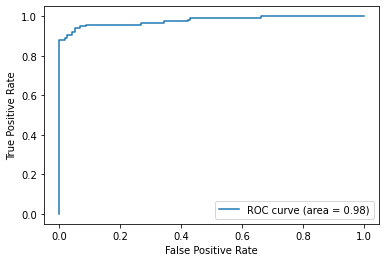

In [41]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
def attention_3d_block(inputs):
    a = Permute((2, 1))(inputs)
    a = Dense(50, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul
def get_attention_model(cnn_x, lstm_x):
    cnn_input = Input(shape=(cnn_x.shape[1],cnn_x.shape[2]), name='cnn_input')
    conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_input)
    cnn_output = AveragePooling1D(pool_size=2, strides=2)(conv1)
    flatten = Flatten()(cnn_output)
    aux_output = Dense(1, activation='sigmoid', name='aux_output')(flatten)
    aux_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='aux_input')
    x = concatenate([cnn_output, aux_input])
    lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(x)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(attention_mul)
    model = Model(inputs=[cnn_input, aux_input], outputs=[main_output, aux_output])
    return model

from tensorflow.keras.models import load_model
from tensorflow import keras
model = get_attention_model(cnn_x, lstm_x)
model.load_weights('./conv_lstm.h5')
pred = np.array(model.predict([cnn_x, lstm_x]))[0]
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(data_y, pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()